In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('read_csv').getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [2]:
t = spark.read.csv('./train.csv', header=True, inferSchema=True)
t.show()

+----------+-----+----+-----+
|      date|store|item|sales|
+----------+-----+----+-----+
|2013-01-01|    1|   1|   13|
|2013-01-02|    1|   1|   11|
|2013-01-03|    1|   1|   14|
|2013-01-04|    1|   1|   13|
|2013-01-05|    1|   1|   10|
|2013-01-06|    1|   1|   12|
|2013-01-07|    1|   1|   10|
|2013-01-08|    1|   1|    9|
|2013-01-09|    1|   1|   12|
|2013-01-10|    1|   1|    9|
|2013-01-11|    1|   1|    9|
|2013-01-12|    1|   1|    7|
|2013-01-13|    1|   1|   10|
|2013-01-14|    1|   1|   12|
|2013-01-15|    1|   1|    5|
|2013-01-16|    1|   1|    7|
|2013-01-17|    1|   1|   16|
|2013-01-18|    1|   1|    7|
|2013-01-19|    1|   1|   18|
|2013-01-20|    1|   1|   15|
+----------+-----+----+-----+
only showing top 20 rows



In [3]:
# date column에서 년, 월, 주차 추출
from pyspark.sql.functions import *

t = t.withColumn('year', date_format(col('date'), 'y').cast("int"))\
        .withColumn('month', date_format(col('date'), 'M').cast("int"))\
            .withColumn('week', date_format(col('date'), 'W').cast("int"))


In [4]:
t.printSchema()

root
 |-- date: string (nullable = true)
 |-- store: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- sales: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week: integer (nullable = true)



In [5]:
t.show(5)

+----------+-----+----+-----+----+-----+----+
|      date|store|item|sales|year|month|week|
+----------+-----+----+-----+----+-----+----+
|2013-01-01|    1|   1|   13|2013|    1|   1|
|2013-01-02|    1|   1|   11|2013|    1|   1|
|2013-01-03|    1|   1|   14|2013|    1|   1|
|2013-01-04|    1|   1|   13|2013|    1|   1|
|2013-01-05|    1|   1|   10|2013|    1|   1|
+----------+-----+----+-----+----+-----+----+
only showing top 5 rows



In [6]:
# 주 단위 데이터 생성(DataFrame 활용)
t.createOrReplaceTempView('rawdf')
# week_it_df = t.groupBy(['year', 'month', 'week', 'item']).agg(sum('sales').alias('week_sales')).orderBy(['year','month','week','item'])
week_si_df = t.groupBy(['year', 'month', 'week', 'store', 'item']).agg(sum('sales').alias('week_sales')).orderBy(['year','month','week','store','item'])

In [9]:
week_si_df.count()

156000

In [10]:
week_si_df.filter((week_si_df.item == 1) & (week_si_df.store == 1)).summary().show()

+-------+------------------+-----------------+------------------+-----+----+------------------+
|summary|              year|            month|              week|store|item|        week_sales|
+-------+------------------+-----------------+------------------+-----+----+------------------+
|  count|               312|              312|               312|  312| 312|               312|
|   mean|2015.0064102564102|6.516025641025641|3.1185897435897436|  1.0| 1.0|116.88461538461539|
| stddev|1.4187390573394645|3.442649036017544|1.5094686992376052|  0.0| 0.0| 47.37100766348726|
|    min|              2013|                1|                 1|    1|   1|                13|
|    25%|              2014|                4|                 2|    1|   1|                86|
|    50%|              2015|                7|                 3|    1|   1|               119|
|    75%|              2016|                9|                 4|    1|   1|               155|
|    max|              2017|            

In [11]:
from itertools import product
from pyspark.sql.functions import row_number,lit
from pyspark.sql.window import Window
from functools import reduce
week_si_df = week_si_df.withColumn('fake_sales', col('week_sales'))

st_it = [list(range(1,11)), list(range(1,51))]
st_it = list(product(*st_it))

lst = []

for i,j in st_it:
    if (i*j) % 3 == 0:
        sub = week_si_df.filter((week_si_df['store']==i) & (week_si_df['item'] == j)).withColumn('fake_sales', \
     when(row_number().over(Window().orderBy(lit('A'))) <= 60,0).otherwise((week_si_df['fake_sales'])))
              
    elif (i*j) % 3 == 1:
        sub = week_si_df.filter((week_si_df['store']==i) & (week_si_df['item'] == j)).withColumn('fake_sales', \
     when(row_number().over(Window().orderBy(lit('A'))).between(101, 160), 0).otherwise((week_si_df['fake_sales'])))

    else:
        sub = week_si_df.filter((week_si_df['store']==i) & (week_si_df['item'] == j)).withColumn('fake_sales', \
     when(row_number().over(Window().orderBy(lit('A'))) >= 260,0).otherwise((week_si_df['fake_sales'])))

    lst.append(sub)

#df_series = reduce(DataFrame.unionAll, lst)


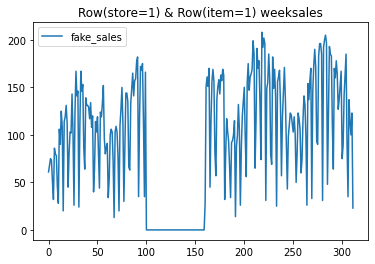

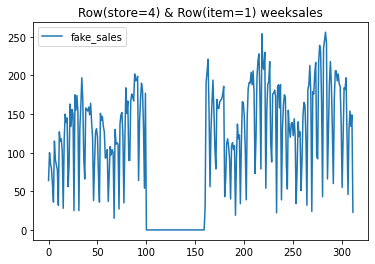

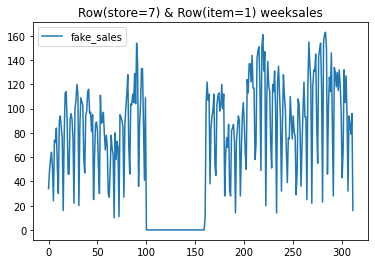

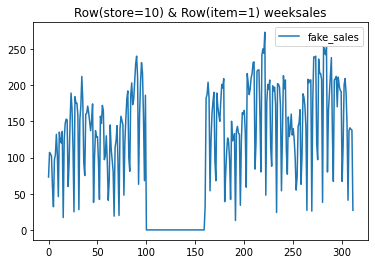

In [116]:
import matplotlib.pyplot as plt
for i in range(0,len(lst),150):
    lst[i].toPandas().plot.line(y='fake_sales',title=f'{lst[i].select("store").distinct().first()} & {lst[i].select("item").distinct().first()} weeksales')

In [118]:
from statsmodels.tsa.stattools import adfuller

for i in range(0,len(lst),150):
	result = adfuller(np.array(lst[i].select('fake_sales').collect()).flatten())
	print(f'{lst[i].select("store").distinct().first()} & {lst[i].select("item").distinct().first()} fake_sales')
	print('ADF Statistic: %f' % result[0])
	print('p-value: %f' % result[1])
	print('Critical Values:')
	for key, value in result[4].items():
		print('\t%s: %.3f' % (key, value))

Row(store=1) & Row(item=1) fake_sales
ADF Statistic: -2.733742
p-value: 0.068379
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
Row(store=4) & Row(item=1) fake_sales
ADF Statistic: -2.886021
p-value: 0.046998
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
Row(store=7) & Row(item=1) fake_sales
ADF Statistic: -2.712290
p-value: 0.071936
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
Row(store=10) & Row(item=1) fake_sales
ADF Statistic: -2.592467
p-value: 0.094564
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


In [80]:
# Store/Item별 sales 데이터 추출 -> 2차원 list로 append
import numpy as np
ts_lst = []
for i in range(len(lst)):
#    ts_lst.append([int(row.fake_sales) for row in week_si_df.filter((week_si_df['store']==i) & (week_si_df['item'] == j)).select('week_sales').collect()])
    ts_lst.append(np.array(lst[i].select('fake_sales').collect()).flatten())

In [84]:

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# DTW 하이퍼 파라미터들 값 지정
def objectiveDTW(trial: Trial, X):
    param = {
        'n_clusters' : trial.suggest_int('n_clusters', 2, 10),
        'n_jobs' : -1,
        'max_iter' : 10,
        'verbose' : 1,
        'metric' : trial.suggest_categorical('metric', ['dtw','softdtw'])
    }
    
    # 학습 모델 생성
    model = TimeSeriesKMeans(**param)
    dtw = model.fit(X) # 학습 진행
    
    # 모델 성능 확인
    score = silhouette_score(ts_lst, dtw.fit_predict(ts_lst), metric='softdtw', n_jobs=-1, verbose=1)
    
    return score
# 실루엣 계수가 최소가 되는 방향으로 학습을 진행
# TPESampler : Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
study = optuna.create_study(direction='maximize', sampler=TPESampler())

# n_trials 지정해주지 않으면, 무한 반복
study.optimize(lambda trial : objectiveDTW(trial, ts_lst), n_trials = 50)

print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-05-18 00:15:06,901] A new study created in memory with name: no-name-61b9589b-bd6c-4f32-b047-1545c25f7d96


674064017913.874 --> 277232434912.375 --> 248240685268.132 --> 243584222673.900 --> 242786026487.490 --> 239921807758.766 --> 234347949572.104 --> 231431060589.952 --> 231378808463.385 --> 229640846435.572 --> 
614227072591.261 --> 268188484062.742 --> 251478172627.566 --> 243073001200.060 --> 236499567518.515 --> 230384882319.487 --> 230106068106.050 --> 227725648543.686 --> 227724042075.584 --> 227625766770.531 --> 


[I 2022-05-18 01:13:24,719] Trial 0 finished with value: 0.5440915592752938 and parameters: {'n_clusters': 9, 'metric': 'softdtw'}. Best is trial 0 with value: 0.5440915592752938.


1696502993044.031 --> 587325548208.738 --> 531003654326.159 --> 525476547881.088 --> 522591472343.655 --> 518875346813.081 --> 515837964457.602 --> 510065512601.786 --> 505772419705.982 --> 500338728069.726 --> 
1706144806711.111 --> 524123758109.588 --> 457165417318.140 --> 458795167419.880 --> 464147575075.647 --> 463649496989.020 --> 463452005067.277 --> 463159191639.603 --> 462997836102.679 --> 462783174516.314 --> 


[I 2022-05-18 02:02:38,295] Trial 1 finished with value: 0.5488071986833938 and parameters: {'n_clusters': 6, 'metric': 'softdtw'}. Best is trial 1 with value: 0.5488071986833938.


3135188615339.690 --> 885687808196.765 --> 823197777224.341 --> 806493257158.220 --> 815627778281.631 --> 811814294801.263 --> 812147394649.168 --> 811711619101.309 --> 811788064937.591 --> 811673370609.901 --> 
2477827107130.416 --> 1188394783762.987 --> 1149652803969.842 --> 1133866845935.097 --> 1122874023351.760 --> 1123568658902.538 --> 1124325608217.869 --> 1125121014174.167 --> 1125653045752.681 --> 1126536727253.591 --> 


[I 2022-05-18 02:47:08,336] Trial 2 finished with value: 0.6196165764275586 and parameters: {'n_clusters': 4, 'metric': 'softdtw'}. Best is trial 2 with value: 0.6196165764275586.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_job

867979.110 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


532070.042 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


501567.565 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


492564.703 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


490321.448 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


487134.269 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


485231.422 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


483375.688 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


478595.814 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


477944.833 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Paral

746495.136 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


531994.273 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


516917.808 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


504247.995 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


499519.049 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


497779.865 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


497004.193 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


496555.266 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


496497.877 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished


496273.288 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:    0.3s finished
[I 2022-05-18 03:08:19,015] Trial 3 finished with value: 0.4920066343325334 and parameters: {'n_clusters': 7, 'metric': 'dtw'}. Best is trial 2 with value: 0.6196165764275586.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Do

1949393.256 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


930280.047 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


898632.519 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


897434.423 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


897285.994 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


897285.994 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapse

1586451.728 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


949721.138 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


927410.008 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


923971.109 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


923837.085 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


923674.584 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


923674.584 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[I 2022-05-18 03:28:41,455] Trial 4 finished with value: 0.638614429472312 and parameters: {'n_clusters': 3, 'metric': 'dtw'}. Best is trial 4 with value: 0.638614429472312.


20742254750683.488 --> 6792024590059.698 --> 4979456293426.048 --> 4258685334069.473 --> 4180636470645.502 --> 3789526591360.851 --> 3777604160523.175 --> 3747377521204.694 --> 3738051695906.066 --> 3704325479864.520 --> 
7199195169770.150 --> 3417596830278.068 --> 3420757201171.530 --> 3460750405242.396 --> 3463292735536.002 --> 3465507305864.334 --> 3464322602258.042 --> 3465513496091.141 --> 3464314545037.640 --> 3460113795688.492 --> 


[I 2022-05-18 04:11:56,549] Trial 5 finished with value: 0.7027572386183202 and parameters: {'n_clusters': 2, 'metric': 'softdtw'}. Best is trial 5 with value: 0.7027572386183202.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_job

1249260.888 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


740934.864 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


726935.829 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


717228.979 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


702117.546 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


675359.407 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


664755.050 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


655171.045 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


639930.947 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


636190.875 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurr

1136727.624 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


718619.993 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


707030.491 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


703196.810 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


698680.400 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


692422.648 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


687055.326 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


682385.746 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


677835.928 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


675406.359 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished
[I 2022-05-18 04:33:30,155] Trial 6 finished with value: 0.5737033554391043 and parameters: {'n_clusters': 5, 'metric': 'dtw'}. Best is trial 5 with value: 0.7027572386183202.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Don

519712.872 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


349406.286 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


342266.996 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


340825.990 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


339911.167 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


339393.531 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


339153.572 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


339036.094 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.5s finished


338859.591 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


338600.853 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_j

546289.844 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


370382.570 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


365184.391 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


362919.687 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


362284.564 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


362019.044 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


361996.808 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


361996.808 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished
[I 2022-05-18 04:53:49,867] Trial 7 finished with value: 0.5267995445909306 and parameters: {'n_clusters': 10, 'metric': 'dtw'}. Best is trial 5 with value: 0.7027572386183202.
[Parallel(n_jobs=-1)]: Using backend Threa

948986.388 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


608532.259 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


576358.634 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


563818.180 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


556882.139 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


546245.770 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


540161.713 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


539427.551 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


539127.763 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


538992.266 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurr

924900.436 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


589913.439 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


577807.271 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


571261.104 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


569944.475 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


569203.609 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


567271.803 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


561899.591 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


559716.855 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


559513.805 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished
[I 2022-05-18 05:14:44,524] Trial 8 finished with value: 0.4990540019316254 and parameters: {'n_clusters': 6, 'metric': 'dtw'}. Best is trial 5 with value: 0.7027572386183202.


12456148186591.943 --> 4306855994289.491 --> 3917886833669.753 --> 3802410252486.113 --> 3799030241049.255 --> 3798564744470.195 --> 3794808494719.625 --> 3790762853747.550 --> 3785705762865.966 --> 3783885057903.832 --> 
18133613350767.199 --> 4394360605160.622 --> 4082034719046.925 --> 4074571811686.868 --> 4067654887390.165 --> 4051308287963.004 --> 4043801266139.756 --> 4027519873004.326 --> 4022473664228.146 --> 4008737797448.073 --> 


[I 2022-05-18 05:55:35,745] Trial 9 finished with value: 0.7034098384754485 and parameters: {'n_clusters': 2, 'metric': 'softdtw'}. Best is trial 9 with value: 0.7034098384754485.


18052744503557.559 --> 5048222146649.230 --> 4901514733830.143 --> 4085664447445.308 --> 4083617978331.154 --> 3916180682990.313 --> 3829024802640.803 --> 3816491395717.091 --> 3802319552062.208 --> 3786740117823.562 --> 
12936798819447.980 --> 3139194588262.240 --> 2935447182726.046 --> 2933158018231.984 --> 2971040768948.317 --> 3005505043840.331 --> 3005343051345.145 --> 3005135740251.952 --> 3004989862258.503 --> 3004841067746.690 --> 


[I 2022-05-18 06:39:04,460] Trial 10 finished with value: 0.6980704404788759 and parameters: {'n_clusters': 2, 'metric': 'softdtw'}. Best is trial 9 with value: 0.7034098384754485.


12846742029874.158 --> 3385516830417.830 --> 3370136690958.496 --> 3369946026687.344 --> 3369707373039.312 --> 3369768705780.600 --> 3369455191651.918 --> 3369338446691.339 --> 3369245531754.411 --> 

KeyboardInterrupt: 

In [85]:
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

Best trial : score 0.7034098384754485, 
params {'n_clusters': 2, 'metric': 'softdtw'}


In [92]:
optuna.visualization.plot_param_importances(study) # 파라미터 중요도 확인 그래프
optuna.visualization.plot_optimization_history(study) # 최적화 과정 시각화

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [82]:
# 베이지안 하이퍼파라미터 조정

from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization


def val(n_clusters):
    dtw = TimeSeriesKMeans(n_clusters=int(n_clusters), metric='softdtw', n_jobs=-1, max_iter=10, verbose=1)
    pred_y = dtw.fit_predict(ts_lst)
    score = silhouette_score(ts_lst, pred_y, metric='softdtw', n_jobs=-1, verbose=1)
     
    return score
 
optimizer = BayesianOptimization(f=val,
    pbounds={'n_clusters': (1,10)})
 
optimizer.maximize(init_points=2, 
                   n_iter=5)
 
print('best result:', optimizer.max)

d:\DS-etrade\mobis\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


|   iter    |  target   | n_clus... |
-------------------------------------
51526018924917.594 --> 14351670500366.871 --> 14337033065513.340 --> 14327914051145.947 --> 14321943510375.645 --> 14317382636338.861 --> 14199916356561.984 --> 14197635958064.920 --> 14195315078067.947 --> 14192971881279.119 --> 


KeyboardInterrupt: 

In [127]:
# pip install tslearn
# DTW clusering 모델 생성
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax,TimeSeriesScalerMeanVariance
ts_dtw_model = TimeSeriesKMeans(n_clusters=3,metric='softdtw', max_iter=10)
ts_dtw_model.fit(np.array(ts_lst).reshape(500,312))
# ts_dtw_model.cluster_centers_.shape

TimeSeriesKMeans(max_iter=10, metric='softdtw')

In [128]:
ts_dtw_model2 = TimeSeriesKMeans(n_clusters=2,metric='softdtw', max_iter=10)
ts_dtw_model2.fit(np.array(ts_lst).reshape(500,312))

TimeSeriesKMeans(max_iter=10, metric='softdtw', n_clusters=2)

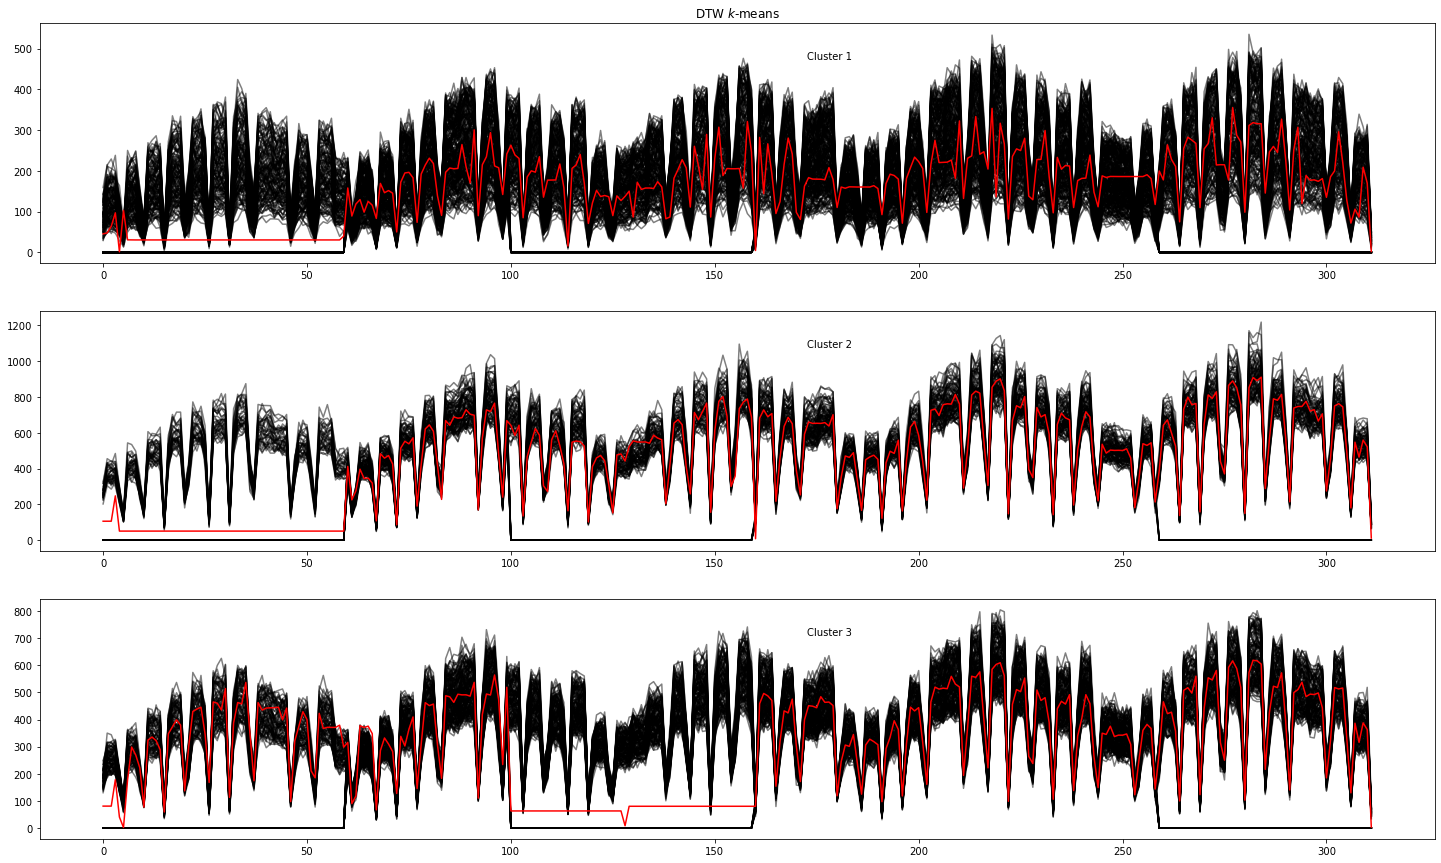

In [153]:
# DTW기반 KMeans 클러스터별 그래프
import numpy as np
import matplotlib.pyplot as plt
ts_lst = np.array(ts_lst)
y_pred = ts_dtw_model.predict(ts_lst)

fig = plt.figure(figsize=(25,15))
for yi in range(3):
    plt.subplot(3, 1, yi+1)
    for xx in ts_lst[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.5)
    plt.plot(ts_dtw_model.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DTW $k$-means")
plt.show()

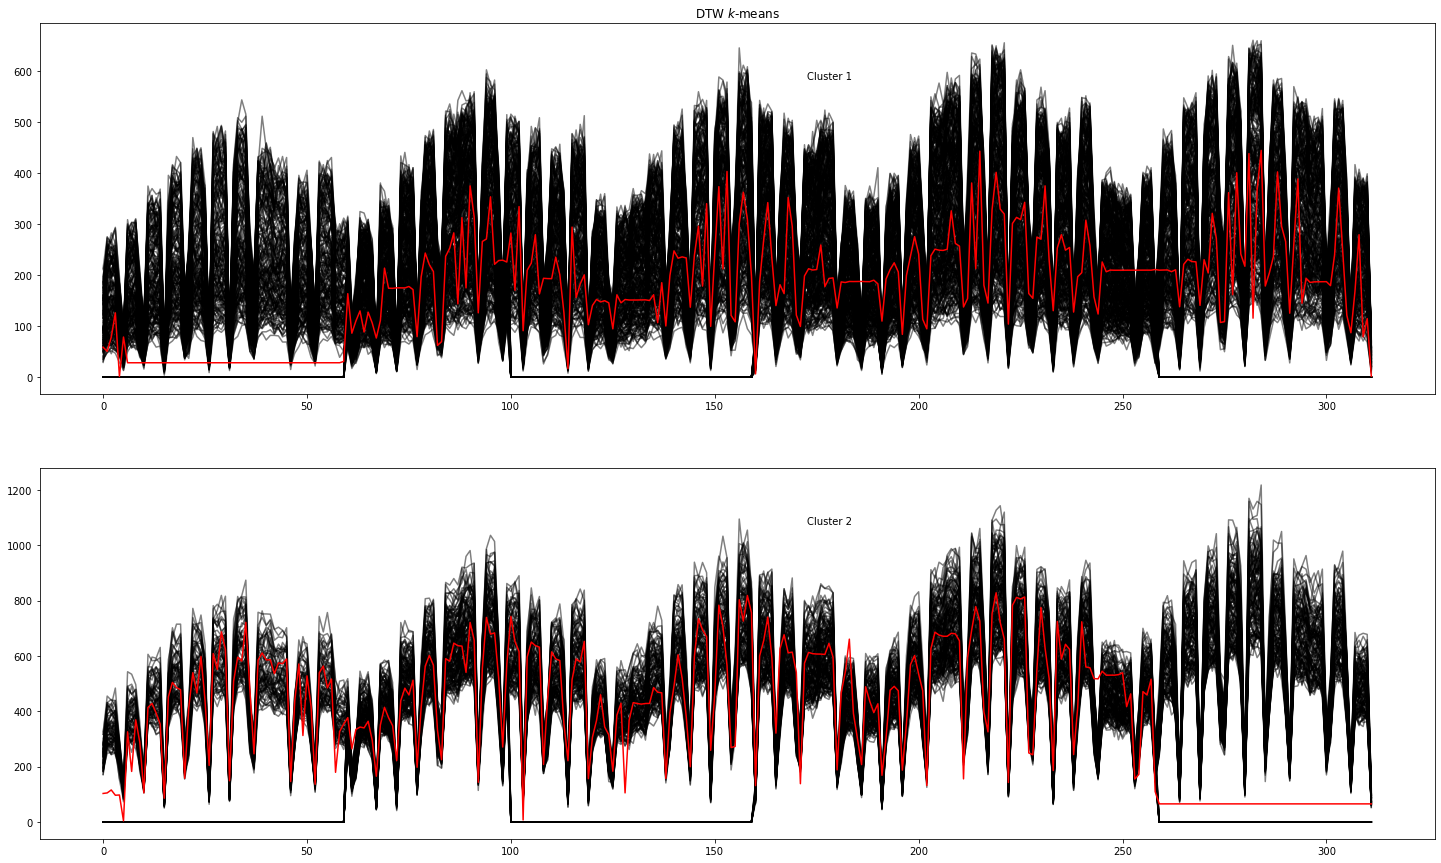

In [154]:
y_pred2 = ts_dtw_model2.predict(ts_lst)

plt.figure(figsize=(25,15))
for yi in range(2):
    plt.subplot(2, 1, 1 + yi)
    for xx in ts_lst[y_pred2 == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.5)
    plt.plot(ts_dtw_model2.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DTW $k$-means")
plt.show()

In [157]:
# 클러스터별 기초 통계량 확인
from collections import Counter
from scipy import stats
print(Counter(y_pred))
for i in range(3):
    print(stats.describe(ts_lst[y_pred==i].flatten()))


Counter({0: 244, 2: 169, 1: 87})
DescribeResult(nobs=76128, minmax=(0, 535), mean=152.2074663724254, variance=12718.94598862577, skewness=0.3056388284905621, kurtosis=-0.7090685226911484)
DescribeResult(nobs=27144, minmax=(0, 1218), mean=437.8419908635426, variance=82624.33464608974, skewness=-0.2467279033025045, kurtosis=-1.136423017501005)
DescribeResult(nobs=52728, minmax=(0, 805), mean=298.79253906842666, variance=39193.34010250667, skewness=-0.1795209662607943, kurtosis=-1.079828635924221)


In [158]:
# 클러스터별 기초통계량
print(Counter(y_pred2))
for i in range(2):
    print(stats.describe(ts_lst[y_pred2==i].flatten()))


Counter({0: 346, 1: 154})
DescribeResult(nobs=107952, minmax=(0, 661), mean=187.59756187935378, variance=21271.884322315556, skewness=0.4573686093686238, kurtosis=-0.5884366332410496)
DescribeResult(nobs=48048, minmax=(0, 1218), mean=394.92245254745256, variance=69993.74131700609, skewness=-0.12078993198367151, kurtosis=-1.022214587343263)


- 상한, 하한 설정 방법

1. 볼린저 밴드 활용: 기본 20일 이평선 +- 2*sigma 

2. ucl, lcl 활용: n개 데이터의 평균 +- 3*sigma

- 평가 지표

SMAPE 활용
